Matrix Factorization in Keras with Gradient Descent Optimization Algorithm.

In [4]:
import os 
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Model 
from keras.layers import Input, Embedding, Dot, Add, Flatten 
from keras.regularizers import l2 
from keras.optimizers import SGD, Adam

In [5]:
# load data 
os.chdir(r'/home/qshan/Desktop/Repos/Big_Data_Projects/Recommender_System/Matrix_Factorization')
df = pd.read_csv('../data/ml-20m/small_ratings.csv')
df.head()

,userId,movieId,rating,movie_idx
0,7307,1,4.5,10
1,7307,10,2.5,68
2,7307,19,3.5,143
3,7307,32,5.0,19
4,7307,39,4.5,85


In [6]:
df.describe()

,userId,movieId,rating,movie_idx
count,5.392025e+06,5.392025e+06,5.392025e+06,5.392025e+06
mean,4.064699e+03,6.735166e+03,3.448249e+00,6.865674e+02
std,2.904367e+03,1.498554e+04,1.016841e+00,5.495762e+02
min,0.000000e+00,1.000000e+00,5.000000e-01,0.000000e+00
25%,1.471000e+03,1.172000e+03,3.000000e+00,2.110000e+02
50%,3.614000e+03,2.289000e+03,3.500000e+00,5.520000e+02
75%,6.432000e+03,4.033000e+03,4.000000e+00,1.078000e+03
max,9.999000e+03,1.093740e+05,5.000000e+00,1.999000e+03


In [8]:
# number of users and movies 
N = df.userId.max() + 1
M = df.movie_idx.max() + 1
print('Max of users id, N =', N, '\n')
print('Max movies id M, =', M, '\n')

Max of users id, N = 10000 

Max movies id M, = 2000 



In [9]:
# randomly shuffle to obtain train and test data 
df = shuffle(df)
cutoff = int(0.8 * len(df))
df_train = df.iloc[ :cutoff]
df_test = df.iloc[cutoff: ]


In [10]:
# initialization 

# latent dimensionality 
K = 10 
# global mean 
mu = df_train.rating.mean()
epochs = 30 
# penalty 
lambda_ = 10.

In [12]:
# Keras model
# two inputs with batch size = 1 
u = Input(shape = (1, ))
m = Input(shape = (1, ))

# (N, 1, K), for a sequence of len 1 as input
u_embedding = Embedding(N, K, embeddings_regularizer = l2(lambda_))(u) 
m_embedding = Embedding(M, K, embeddings_regularizer = l2(lambda_))(m)

# subsubmodel = Model([u, m], [u_embedding, m_embedding])
# user_ids = df_train.userId.values[0:5]
# movie_ids = df_train.movie_idx.values[0:5]
# print("user_ids.shape", user_ids.shape)
# p = subsubmodel.predict([user_ids, movie_ids])
# print("p[0].shape:", p[0].shape)
# print("p[1].shape:", p[1].shape)
# exit()


Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# Keras model bias terms 
u_bias = Embedding(N, 1, embeddings_regularizer = l2(lambda_))(u) # (N ,1 ,1)
m_bias = Embedding(M, 1, embeddings_regularizer = l2(lambda_))(m) # (M, 1, 1)

# multiply user vector and movie vector together 
# collapse on (sum over) the K size axis of (N, 1, K) for u_embedding
x = Dot(axes = 2)([u_embedding, m_embedding]) # (N, 1, 1)

# add together 
x = Add()([x, u_bias, m_bias])
# (N, 1, 1) --> (N, 1)
x = Flatten()(x)

In [14]:
# build model 
model = Model(inputs = [u, m], outputs = x)

# compile 
# if there is penalty, mse from loss includes regularization, will be bigger than real mse (metrics mse)
model.compile(loss = 'mse', optimizer = SGD(lr = 0.08, momentum = 0.9), metrics = ['mse'])

# fit model 
r = model.fit(
              x = [df_train.userId.values, df_train.movie_idx.values],
              y = df_train.rating.values - mu,
              epochs = epochs, 
              batch_size = 128, 
              validation_data = ([df_test.userId.values, df_test.movie_idx.values],
                                  df_test.rating.values - mu))

Instructions for updating:
Use tf.cast instead.
Train on 4313620 samples, validate on 1078405 samples
Epoch 1/30
4313620/4313620 [==============================] - 113s 26us/step - loss: 0.6951 - mean_squared_error: 0.6951 - val_loss: 0.6793 - val_mean_squared_error: 0.6793
Epoch 2/30
4313620/4313620 [==============================] - 115s 27us/step - loss: 0.6648 - mean_squared_error: 0.6648 - val_loss: 0.6429 - val_mean_squared_error: 0.6429
Epoch 3/30
4313620/4313620 [==============================] - 116s 27us/step - loss: 0.6137 - mean_squared_error: 0.6137 - val_loss: 0.6003 - val_mean_squared_error: 0.6003
Epoch 4/30
4313620/4313620 [==============================] - 127s 29us/step - loss: 0.5762 - mean_squared_error: 0.5762 - val_loss: 0.5737 - val_mean_squared_error: 0.5737
Epoch 5/30
4313620/4313620 [==============================] - 123s 28us/step - loss: 0.5506 - mean_squared_error: 0.5506 - val_loss: 0.5591 - val_mean_squared_error: 0.5591
Epoch 6/30
4313620/4313620 [=====

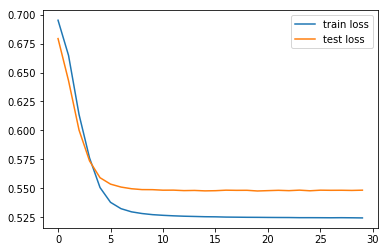

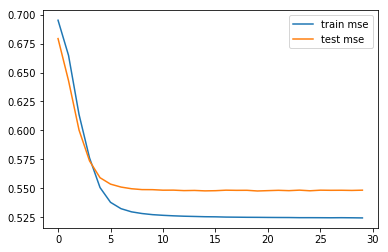

In [15]:
# plot 
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['mean_squared_error'], label="train mse")
plt.plot(r.history['val_mean_squared_error'], label="test mse")
plt.legend()
plt.show()